In [1]:
import os
import glob
import gzip
import pickle
import pandas as pd
import numpy as np
import multiprocessing

from datetime import datetime
import pytz

from matplotlib import pyplot as plt
%matplotlib inline

import networkx as nx

from tsvar.preprocessing import Dataset

Set larger cell width

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## 1. Load the raw MemeTracker dataframe

Load raw dataframes (in parallel)

In [3]:
list_df_files = sorted(glob.glob('/root/workspace/nphc/nphc/datasets/memetracker/data/df_*.csv'))

def worker(fname):
    return pd.read_csv(fname)

pool = multiprocessing.Pool(len(list_df_files))

jobs = list()
for fname in list_df_files:
    job = pool.apply_async(worker, (fname, ))
    jobs.append(job)

data = list()
for job in jobs:
    data.append(job.get())

df = pd.concat(data, ignore_index=True)
del data

pool.close()
pool.terminate()

* `Blog` = receiver
* `Hyperlink` = sender

Vizualize the dataset

In [7]:
print(df.shape)
df

(141578503, 5)


,Date,Hyperlink,Blog,PostNb,WeightOfLink
0,2008-08-01 00:00:00,,http://codeproject.com,0,1.0
1,2008-08-01 00:00:01,,http://wallstreetexaminer.com,1,1.0
2,2008-08-01 00:00:01,,http://news.bbc.co.uk,2,1.0
3,2008-08-01 00:00:01,,http://news.bbc.co.uk,3,1.0
4,2008-08-01 00:00:01,,http://news.bbc.co.uk,4,1.0
...,...,...,...,...,...
141578498,2009-05-01 00:00:00,http://foulweather.blogspot.com,http://foulweather.blogspot.com,15312736,0.2
141578499,2009-05-01 00:00:00,http://2.bp.blogspot.com,http://foulweather.blogspot.com,15312736,0.2
141578500,2009-05-01 00:00:00,http://dischord.com,http://foulweather.blogspot.com,15312736,0.2
141578501,2009-05-01 00:00:00,http://stream.publicbroadcasting.net,http://foulweather.blogspot.com,15312736,0.2


Save it for later use

---

## 2. Clean the dataframe

### 2.1. Clean columns

#### Clean the `Hyperlink column`

In [8]:
df['Hyperlink'] = df['Hyperlink'].str.strip()  # Remove whitespaces

#### Cast `Date` and build timestamps

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Timestamp'] = df['Date'].values.astype(np.int64) // (10 ** 9)

# NOTE: We don't use a time-zone here, so to get back the same datetime, we need to use: 
# df_filtered.Timestamp.apply(lambda t: datetime.fromtimestamp(t - 2*3600))

### 2.2. Filter invalid events

#### Self-references

Only keep cross-references between different sites (i.e., remove self references)

In [10]:
cross_event_mask = df.Hyperlink != df.Blog
print(f'{np.sum(cross_event_mask):,d} events are cross-sites'
      f' out of the {len(df):,d} ({np.sum(cross_event_mask)*100/len(df):.2f}%)')

111,893,425 events are cross-sites out of the 141,578,503 (79.03%)


#### Blogs with no hyperlink

In [11]:
null_hp_mask = df.Hyperlink.apply(len) == 0  # Build mask of valid hyperlinks
print(f'{np.sum(null_hp_mask):,d} posts have zero hyperlinks'
      f'out of the {len(df):,d} ({np.sum(null_hp_mask)*100/len(df):.2f}%)')

39,875,581 posts have zero hyperlinksout of the 141,578,503 (28.16%)


Filter the dataframe based on these masks

In [12]:
valid_event_mask = (
    #~null_hp_mask &     # Keep only events with non-null hyperlink
    #cross_event_mask &  # Keep only cross-site events
    np.ones(len(df)).astype(bool)
)

print(f'Keep {np.sum(valid_event_mask):,d}'
      f' out of the {len(df):,d} events ({np.sum(valid_event_mask)*100/len(df):.2f}%)')

df_filtered = df.loc[valid_event_mask]
display(df_filtered)

Keep 141,578,503 out of the 141,578,503 events (100.00%)


,Date,Hyperlink,Blog,PostNb,WeightOfLink,Timestamp
0,2008-08-01 00:00:00,,http://codeproject.com,0,1.0,1217548800
1,2008-08-01 00:00:01,,http://wallstreetexaminer.com,1,1.0,1217548801
2,2008-08-01 00:00:01,,http://news.bbc.co.uk,2,1.0,1217548801
3,2008-08-01 00:00:01,,http://news.bbc.co.uk,3,1.0,1217548801
4,2008-08-01 00:00:01,,http://news.bbc.co.uk,4,1.0,1217548801
...,...,...,...,...,...,...
141578498,2009-05-01 00:00:00,http://foulweather.blogspot.com,http://foulweather.blogspot.com,15312736,0.2,1241136000
141578499,2009-05-01 00:00:00,http://2.bp.blogspot.com,http://foulweather.blogspot.com,15312736,0.2,1241136000
141578500,2009-05-01 00:00:00,http://dischord.com,http://foulweather.blogspot.com,15312736,0.2,1241136000
141578501,2009-05-01 00:00:00,http://stream.publicbroadcasting.net,http://foulweather.blogspot.com,15312736,0.2,1241136000


Percentage of non-empty hyperlinks

In [13]:
np.sum(df_filtered.Hyperlink != '') * 100 / len(df_filtered)

71.83500308659147

Remove the raw dataframe, we only work on the filtered one from now on.

### 2.3. Find the top-100 blogs

In [14]:
df_filtered['has_hyperlink'] = df_filtered.Hyperlink != ''  # Indicate if event has hyperlink
df_filtered['has_hyperlink'] = df_filtered['has_hyperlink'].astype(int)

Build the count of number of hyperlink per blogs, i.e., how many times a blog was cited.

Build the count of number of posts per blogs.

In [15]:
count_series = df_filtered.groupby('Blog').agg({'PostNb': set})['PostNb'].apply(len)

Keep only the top-100 sites

In [16]:
top_num = 100

top_series = count_series.sort_values(ascending=False).iloc[:top_num]
print(f'There are {top_series.sum():,d} items in the top-{top_num:d} sites')
display(top_series)

There are 24,280,563 items in the top-100 sites


Blog
http://blogs.myspace.com           1721787
http://seattle.craigslist.org       908675
http://sfbay.craigslist.org         848217
http://chicago.craigslist.org       832027
http://blog.myspace.com             793208
                                    ...   
http://huffingtonpost.com            82245
http://sandmountainreporter.com      77939
http://twitter.com                   76874
http://forbes.com                    76804
http://rss.rssad.jp                  76273
Name: PostNb, Length: 100, dtype: int64

### 2.3. Keep only events between sites in the top-100 blogs

We finally remove all events coming from hyperlinks that are not part of the top-100 blogs.

In [17]:
top_site_set = set(top_series.index.tolist())  # All top blog sites

top_blog_mask = df_filtered['Blog'].isin(top_site_set)     # Blogs is in top
top_hp_mask = df_filtered['Hyperlink'].isin(set(list(top_site_set) + ['']))  # Hyperlink is in top or no hyperlink (i.e. is null)

In [18]:
# Build mask of valid events
valid_event_mask = top_blog_mask & top_hp_mask

# Filter
df_top = df_filtered.loc[valid_event_mask]
assert len(df_top) == np.sum(valid_event_mask)

print(f'{np.sum(valid_event_mask):,d} events are between the top-{top_num} sites'
      f' out of the {len(df_filtered):,d} ({np.sum(valid_event_mask)*100/len(df_filtered):.2f}%)')

15,168,774 events are between the top-100 sites out of the 141,578,503 (10.71%)


In [19]:
df_top

,Date,Hyperlink,Blog,PostNb,WeightOfLink,Timestamp,has_hyperlink
2,2008-08-01 00:00:01,,http://news.bbc.co.uk,2,1.0,1217548801,0
3,2008-08-01 00:00:01,,http://news.bbc.co.uk,3,1.0,1217548801,0
4,2008-08-01 00:00:01,,http://news.bbc.co.uk,4,1.0,1217548801,0
320,2008-08-01 00:00:46,,http://in.news.yahoo.com,230,1.0,1217548846,0
357,2008-08-01 00:00:48,,http://in.news.yahoo.com,264,1.0,1217548848,0
...,...,...,...,...,...,...,...
141578433,2009-04-30 23:59:57,,http://groups.google.com,15312686,1.0,1241135997,0
141578435,2009-04-30 23:59:57,,http://groups.google.com,15312688,1.0,1241135997,0
141578485,2009-04-30 23:59:59,,http://bizjournals.com,15312725,1.0,1241135999,0
141578487,2009-04-30 23:59:59,,http://blogs.myspace.com,15312727,1.0,1241135999,0


Percentage of non-empty hyperlinks

In [20]:
np.sum(df_top.Hyperlink != '') * 100 / len(df_top)

47.81617156403016

In [21]:
blog_set = set(df_top.Blog)
hp_set = set(df_top.Hyperlink)

In [22]:
len(blog_set)

100

In [23]:
len(hp_set)

99

In [24]:
len(hp_set.intersection(blog_set))

98

Build numerical index for each blog

In [25]:
top_name_to_idx_map = dict(zip(top_series.index, range(top_num)))

# Make numerical index for blogs
df_top['Blog_idx'] = df_top['Blog'].apply(lambda name: top_name_to_idx_map[name])

# Add hyperlinks index
top_name_to_idx_map[''] = None  # Set -1 for No-Hyperlink
df_top['Hyperlink_idx'] = df_top['Hyperlink'].apply(lambda name: top_name_to_idx_map[name]) 

In [26]:
display(df_top.sample(10))

,Date,Hyperlink,Blog,PostNb,WeightOfLink,Timestamp,has_hyperlink,Blog_idx,Hyperlink_idx
131149333,2009-04-22 15:02:47,http://pr-inside.com,http://pr-inside.com,9917477,0.166667,1240412567,1,23,23.0
100066046,2009-03-04 08:10:19,,http://forum.gateworld.net,2066122,1.000000,1236154219,0,55,NaN
25365019,2008-10-02 20:44:12,http://ar.answers.yahoo.com,http://ar.answers.yahoo.com,683798,1.000000,1222980252,1,11,11.0
141186631,2009-04-30 12:34:54,http://mx.answers.yahoo.com,http://mx.answers.yahoo.com,15042768,1.000000,1241094894,1,12,12.0
97597708,2009-03-01 08:21:33,,http://times-journal.com,302601,1.000000,1235895693,0,50,NaN
67131618,2009-01-05 22:34:49,,http://bertelsmann-stiftung.de,1218000,1.000000,1231194889,0,77,NaN
39700055,2008-11-03 05:27:00,http://ca.answers.yahoo.com,http://ca.answers.yahoo.com,536415,1.000000,1225690020,1,26,26.0
103653192,2009-03-09 20:20:53,http://pr-inside.com,http://pr-inside.com,4651879,0.500000,1236630053,1,23,23.0
97718710,2009-03-01 11:05:57,,http://blogs.myspace.com,402547,1.000000,1235905557,0,0,NaN
4150421,2008-08-13 00:33:20,,http://news.google.com,2814798,1.000000,1218587600,0,32,NaN


We only work with the top blogs from now on.

## 3. Build point process

Aggregate events per Blog

In [27]:
df_tpp = df_top.groupby('Blog').agg({'Timestamp': list, 'Hyperlink': list, 'Blog_idx': 'first', 'Hyperlink_idx': list})

In [28]:
df_tpp['Count'] = df_tpp['Timestamp'].apply(len)
df_tpp = df_tpp.sort_values(by='Count')

In [29]:
df_tpp

,Timestamp,Hyperlink,Blog_idx,Hyperlink_idx,Count
Blog,,,,,
http://rss.rssad.jp,"[1217561050, 1217561050, 1217561050, 121756105...","[http://twitter.com, http://twitter.com, http:...",99,"[97.0, 97.0, 97.0, 97.0, 97.0, 25.0, 25.0, 31....",1723
http://forums.seroundtable.com,"[1217637788, 1217637788, 1217637788, 121778864...","[, , , , , http://forums.seroundtable.com, htt...",56,"[nan, nan, nan, nan, nan, 56.0, 56.0, nan, nan...",1743
http://answers.polldaddy.com,"[1227662993, 1227670206, 1227675626, 122767742...","[http://answers.polldaddy.com, http://answers....",52,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, nan...",3043
http://washingtondc.craigslist.org,"[1217559137, 1217561639, 1217562989, 121756401...","[, , , , , , , , , , , , , , , , , , , , , , ,...",16,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3321
http://wordle.net,"[1217550020, 1217550020, 1217550020, 121755002...","[, , , , , , , , , , , , , , , , , , , , , , ,...",39,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4227
...,...,...,...,...,...
http://sportsnipe.com,"[1218863834, 1218863835, 1218863835, 121886383...","[http://sportsnipe.com, http://sportsnipe.com,...",13,"[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....",458599
http://mx.answers.yahoo.com,"[1217550871, 1217553309, 1217553309, 121755330...","[, , , , , , , , , , , , , , , , , , , , , , ,...",12,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",482981
http://ar.answers.yahoo.com,"[1217551046, 1217555877, 1217555877, 121755587...","[, , , , , , , , , , , , , , , , , , , , , , ,...",11,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",483757


In [30]:
df_tpp.to_pickle('/root/workspace/var-wold/data/memetracker/df_tpp.pk')

## 4. Build influence graph

Build the adjacency matrix in parallel for each node

In [42]:
def worker(blog, row):
    mu_mat = np.zeros(100)
    adj_mat = np.zeros((100, 100))
    blog_idx = row['Blog_idx']
    for hp_idx in row['Hyperlink_idx']:
        if np.isnan(hp_idx):
            mu_mat[blog_idx] += 1
            continue
        hp_idx = int(hp_idx)
        adj_mat[hp_idx][blog_idx] += 1
    return mu_mat, adj_mat

pool = multiprocessing.Pool(40)

jobs = list()
for blog, row in df_tpp.iterrows():
    job = pool.apply_async(worker, (blog, row, ))
    jobs.append(job)

mu_mat = np.zeros(100)
adj_mat = np.zeros((100, 100))
for i, job in enumerate(jobs):
    this_mu_mat, this_adj_mat = job.get()
    mu_mat += this_mu_mat
    adj_mat += this_adj_mat
    print(f"\rFinished job {i}/{len(jobs)}", end='')
    
pool.close()
pool.terminate()

Finished job 99/100

In [43]:
import networkx as nx
graph = nx.DiGraph(adj_mat)
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())
print('Number of self-loops:', graph.number_of_selfloops())

Number of nodes: 100
Number of edges: 985
Number of self-loops: 93


## 5. Visualize the dataset

count    1.000000e+02
mean     1.516877e+05
std      1.937082e+05
min      1.723000e+03
25%      7.706900e+04
50%      1.057855e+05
75%      1.740125e+05
max      1.624574e+06
Name: Count, dtype: float64


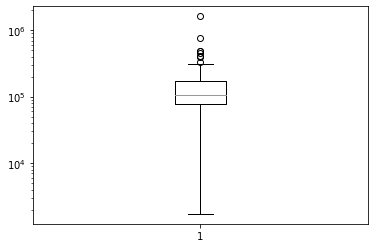

In [44]:
plt.boxplot(df_tpp.Count)
plt.yscale('log');
print(df_tpp.Count.describe())

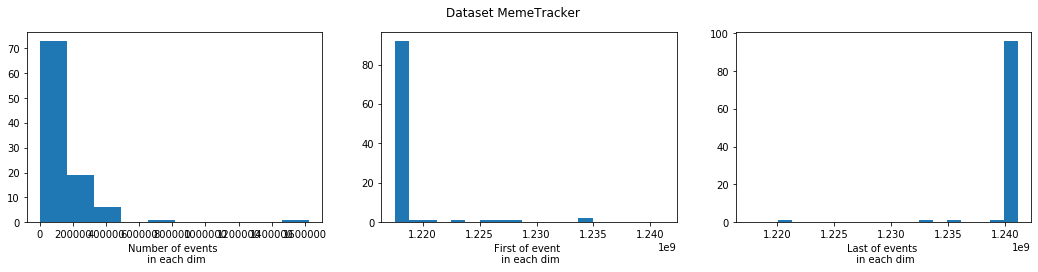

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, df_tpp.Timestamp)))
axs[0].set_xlabel('Number of events \n in each dim')

start_time = min(map(min, df_tpp.Timestamp))
end_time = max(map(max, df_tpp.Timestamp))

axs[1].hist(list(map(min, df_tpp.Timestamp)), bins=np.linspace(start_time, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, df_tpp.Timestamp)), bins=np.linspace(start_time, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset MemeTracker");

In [67]:
sum(map(len, df_tpp.Timestamp))

15168774

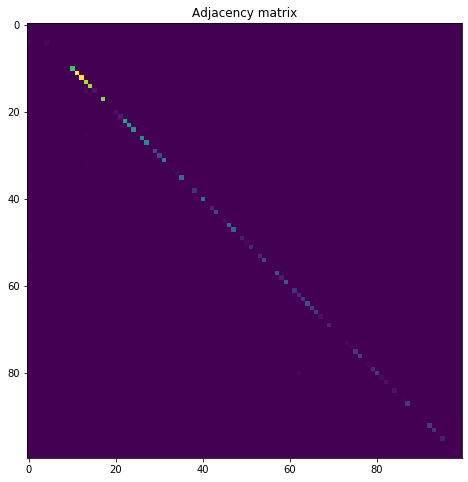

In [48]:
plt.figure(figsize=(8, 8))
plt.imshow(adj_mat)
plt.title('Adjacency matrix');

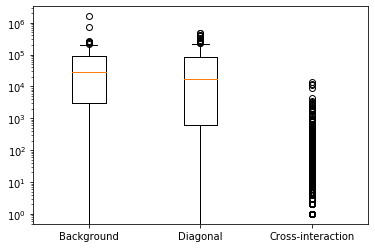

In [50]:
diag_mask = np.eye(adj_mat.shape[0]).astype(bool)
plt.boxplot([mu_mat, adj_mat[diag_mask], adj_mat[~diag_mask]], labels=['Background', 'Diagonal', 'Cross-interaction']);
plt.yscale('log');

## 7. Make the dataset

In [68]:
dim = 100
nodes = list(range(100))

# Build index to name map
idx_to_name = dict(zip(top_name_to_idx_map.values(), top_name_to_idx_map.keys()))
assert len(set(idx_to_name).intersection(nodes)) == dim

# arrays of timestamps
timestamps = [np.array(df_tpp['Timestamp'].loc[idx_to_name[i]]) for i in nodes]
start_time = min(map(min, timestamps))
timestamps = [arr - start_time for arr in timestamps]

# Build directed graph from adjacency matrix
graph = nx.DiGraph(adj_mat)

dataset = Dataset.from_data(timestamps=timestamps, idx_to_name=idx_to_name, graph=graph, timescale='median')
dataset.end_time = max(map(max, dataset.timestamps))

In [69]:
dataset.end_time = max(map(max, dataset.timestamps))

In [70]:
with open('/root/workspace/var-wold/data/memetracker/dataset_memetracker_good.pk', 'wb') as f:
    pickle.dump(dataset, f)